# Avance 5 Modelo Final 

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335


In [21]:
import warnings
warnings.filterwarnings('ignore')

# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2

# Librerias para el manejo del ambiente y documentos
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))


import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
# import json

# Librerias Locales del Repositorio.
from watermark.features import Utilities, Encription_images
from watermark.dataset import DataHandler

# Librerias de Procesamiento de Imagenes
import pywt  # Wavelet transform
from scipy.fftpack import dct
from imagehash import phash  # Librería para hash perceptual

# Librerias de Machine Learning
from PIL import Image
import torch
from torchvision import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
dh = DataHandler()
util = Utilities()
encript = Encription_images()

## Generar Imagenes de Ataques

In [2]:
# Definir directorios
original_dir = Path("DataSet")  # Carpeta con imágenes originales
altered_dir = Path("altered_traces")  # Carpeta para imágenes alteradas

# Crear directorios si no existen
altered_dir.mkdir(parents=True, exist_ok=True)

# Transformaciones a aplicar
def apply_transformations(image):
    transformations = {}
    
    # 1. Compresión JPEG
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]  # Calidad 50
    _, compressed = cv2.imencode(".jpg", image, encode_param)
    transformations["compressed"] = cv2.imdecode(compressed, cv2.IMREAD_COLOR)
    
    # 2. Agregar Ruido Gaussiano
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    transformations["noisy"] = noisy_image
    
    # 3. Recorte
    h, w = image.shape[:2]
    cropped = image[int(0.1*h):int(0.9*h), int(0.1*w):int(0.9*w)]  # Recorte central
    transformations["cropped"] = cv2.resize(cropped, (w, h))  # Reescalar al tamaño original
    
    # 4. Rotación 15 grados
    M = cv2.getRotationMatrix2D((w//2, h//2), 15, 1)
    rotated = cv2.warpAffine(image, M, (w, h))
    transformations["rotated"] = rotated

    return transformations



In [ ]:
# Procesar imágenes originales
for img_path in original_dir.glob("*.png"):
    img = cv2.imread(str(img_path))
    
    # Guardar original
    cv2.imwrite(str(altered_dir / f"{img_path.stem}_original.png"), img)
    
    # Aplicar transformaciones y guardar
    altered_images = apply_transformations(img)
    for name, altered_img in altered_images.items():
        cv2.imwrite(str(altered_dir / f"{img_path.stem}_{name}.png"), altered_img)

print(f"Se generaron {len(list(altered_dir.glob('*.png')))} imágenes alteradas.")


## Proceso de Ataque a Mano

In [36]:
# Cargar el modelo ResNet101 preentrenado
resnet101 = models.resnet101(pretrained=True)

# Remover la capa final de clasificación (la capa fc)
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])

resnet101.eval()  # Poner el modelo en modo evaluación

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [37]:
# Definir la ruta del directorio donde están las imágenes
imagen_original = "altered_traces/task0_user_0_original.png"
# imagen_atacada = "altered_traces/task6_user_0_original.png"
imagen_atacada = "altered_traces/task0_user_0_rotated.png"
# imagen_atacada = "altered_traces/task0_user_0_compressed.png"
# imagen_atacada = "altered_traces/task1_user_0_noisy.png"

image_array = []
feature_array = []

# Abrir la imagen (convertirla a RGB si es necesario)
img_og = Image.open(imagen_original).convert('RGB')
img_att = Image.open(imagen_atacada).convert('RGB')

# Imagen en pocision 0 es la original y la pos 1 es la atacada
image_array = [img_og, img_att]



for image in image_array:
  # Preprocesar la imagen para ResNet101 (usa tu función de preprocesamiento)
  img_tensor = dh.preprocesar_imagen_tensor(image)

  feature_map = resnet101(img_tensor)  # Salida de las capas convolucionales y pooling

  # Aplanar el tensor de características para obtener el vector de características
  feature_vector = feature_map.view(feature_map.size(0), -1)  # Aplanar a un vector de 2048 dimensiones

  feature_array.append(feature_vector)

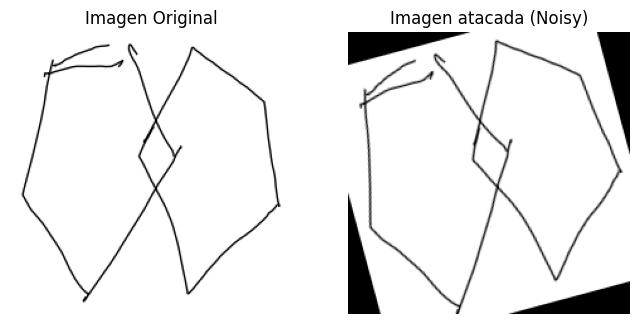

In [38]:
image_title = ['Imagen Original', 'Imagen atacada (Noisy)']
def show_2_img(img_arr, title_arr, n=2):
  plt.figure(figsize=(n*4,n*4), constrained_layout=False)
  for idx, image in enumerate(img_arr):
    plt.subplot(1,n,idx+1)
    plt.imshow(image, cmap="gray")
    plt.title(title_arr[idx])
    plt.axis("off")
  plt.show()

show_2_img(image_array, image_title)

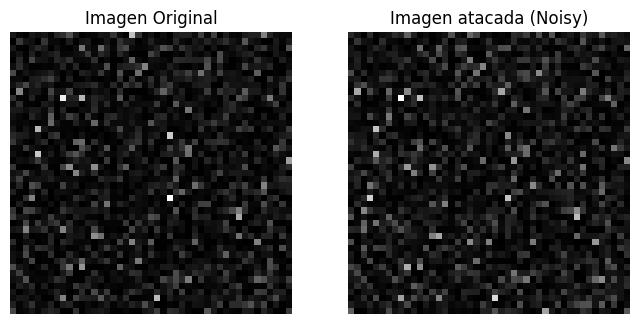

In [39]:
image_feature_arr = []
# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
  for idx, feature_vector in enumerate(feature_array):
    feat_vect = feature_vector.tolist()[0]
    feat_vect = np.array(feat_vect[:2025]).reshape(45,45)
    image_feature_arr.append(feat_vect)


image_title = ['Imagen Original', 'Imagen atacada (Noisy)']
show_2_img(image_feature_arr, image_title)

In [40]:
# Lista para almacenar los vectores de características con DWT, DCT y hash perceptual
feature_vectors_dwt_dct_hash = []
image_feature_arr = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre cada vector de características (tienes 902 vectores)
    for idx, feature_vector in enumerate(feature_array):        
        # Aplicar DWT sobre el vector de características (usando una transformación 1D)
        coeffs = pywt.dwt(feature_vector.squeeze().cpu().numpy(), 'db1')  # 'db1' es un tipo de wavelet común (Daubechies)
        cA, cD = coeffs  # Coeficientes aproximados (cA) y detalles (cD)
        
        # Aplicar DCT sobre los coeficientes aproximados (cA)
        cA_dct = dct(cA, norm='ortho')
        
        # Extraer los primeros 64 coeficientes válidos de la DCT
        low_freq_coeffs = cA_dct[:64].reshape(8,8)  # Tomamos los primeros 32 coeficientes
        
        # # Normalizar los coeficientes para que estén en [0, 255] y convertir a uint8
        # low_freq_matrix_norm = np.uint8(np.interp(low_freq_coeffs, 
        #                                           (low_freq_coeffs.min(), low_freq_coeffs.max()), 
        #                                           (0, 255)))

        # Convertir la matriz en imagen PIL
        img = Image.fromarray(low_freq_coeffs, mode="L")
        image_feature_arr.append(img)

        # Aplicar el perceptual hash con un tamaño mayor (32x32 bits)
        ph = phash(img, hash_size=32)  

        # Convertir el hash en una matriz 32x32
        hash_matrix = np.array(ph.hash, dtype=int)

        # Guardar el hash en formato de matriz
        feature_vectors_dwt_dct_hash.append(hash_matrix)

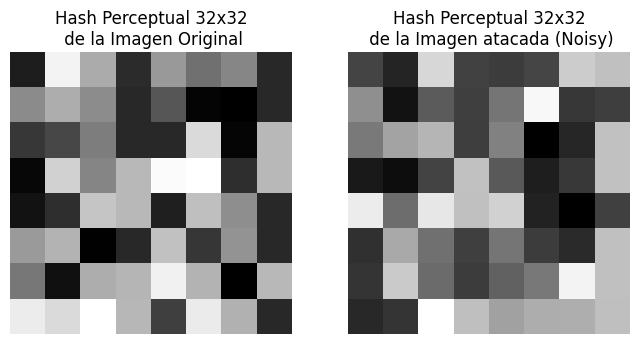

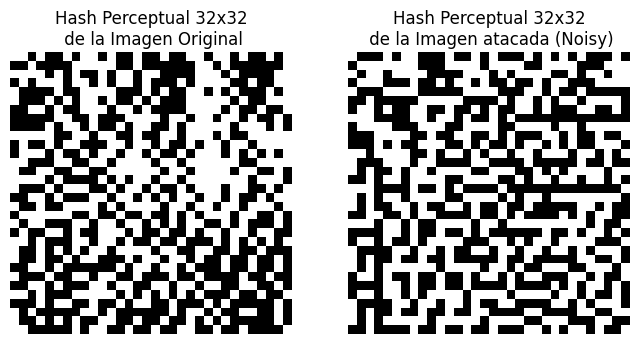

In [41]:
image_title = ['Hash Perceptual 32x32\n de la Imagen Original', 
               'Hash Perceptual 32x32\n de la Imagen atacada (Noisy)']
show_2_img(image_feature_arr, image_title)
show_2_img(feature_vectors_dwt_dct_hash, image_title)

In [42]:
# Generamos Fechas Aleatorias ejemplo para hacer la funcion
date = '2025/02/23 04:54:11'#util.dates_generator(1)[0]
print('Fecha a Utilizar: ', date)


binario = ''.join(format(ord(c), '08b') for c in date)  # 8 bits por carácter
print(len(binario))
# 2. Asegurar que tenemos 1024 bits (32x32)
faltantes = 1024 - len(binario)
if faltantes > 0:
    relleno = '0' * faltantes
    binario += ''.join(relleno)  # Rellenar con 0


# Convertir a matriz 32x32
bit_array = np.array([int(b) for b in binario[:1024]]).reshape(32, 32)
# bit_array_binary = bit_array.copy()
bit_array[bit_array == 1] = 255
# bit_array = np.where(bit_array == 1,255, 0)  # Convertir a escala de grises

# # 3. Crear imagen a partir de la matriz de bits
# fecha_image = Image.fromarray(np.uint8(bit_array), mode="L")

Fecha a Utilizar:  2025/02/23 04:54:11
152


In [43]:
# Aplicar el cifrado caótico
encrypted_img, chaos_idx = util.logistic_map_encrypt(bit_array)
print(encrypted_img)
encrypted_img[encrypted_img == 255] = 1
print(encrypted_img)

# Verificar forma de la imagen
print("Forma de la imagen cifrada:", encrypted_img.shape)
print("Indice de Caos", chaos_idx)



[[  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255   0   0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
Forma de la imagen cifrada: (32, 32)
Indice de Caos [  1 937 100 ...  99 936   0]


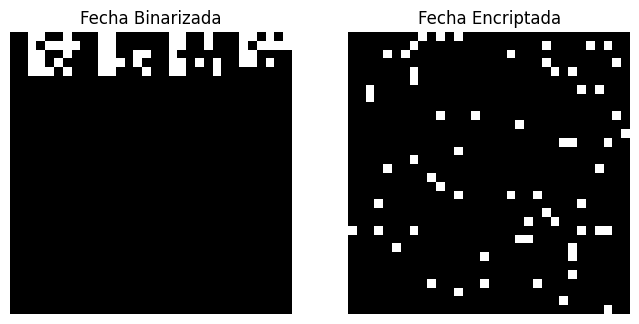

In [44]:
image_arr = [bit_array, encrypted_img]
image_title = ['Fecha Binarizada', 
               'Fecha Encriptada']
show_2_img(image_arr, image_title)

[[1 1 0 ... 1 0 1]
 [0 0 1 ... 1 0 1]
 [1 1 1 ... 0 1 1]
 ...
 [1 0 1 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [1 1 0 ... 1 0 1]]


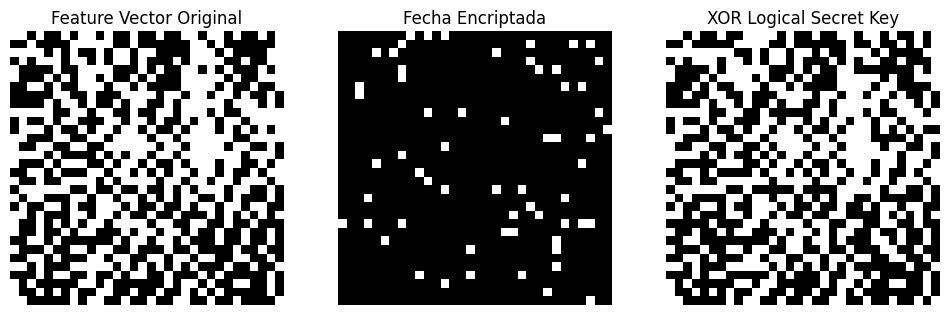

In [45]:
# Convertir la imagen de PIL a un array NumPy en escala de grises
#encrypted_img = encrypted_img#np.array(encrypted_img, dtype=np.uint8)
phash_matrix = feature_vectors_dwt_dct_hash[0]#np.array(feature_vectors_dwt_dct_hash[0], dtype=np.uint8)

# Asegurar que las dimensiones coinciden
if encrypted_img.shape != phash_matrix.shape:
  raise ValueError(f"Dimensiones incompatibles: {phash_matrix.shape} vs {encrypted_img.shape}")

# Aplicar XOR para generar la Logical Secret Key
logical_secret_key = np.bitwise_xor(encrypted_img, phash_matrix)
print(logical_secret_key)

# Mostrar la imagen con matplotlib
image_title = ['Feature Vector Original', 
               'Fecha Encriptada',
               'XOR Logical Secret Key']
image_foto = [phash_matrix, encrypted_img, logical_secret_key]
show_2_img(image_foto, image_title, 3)


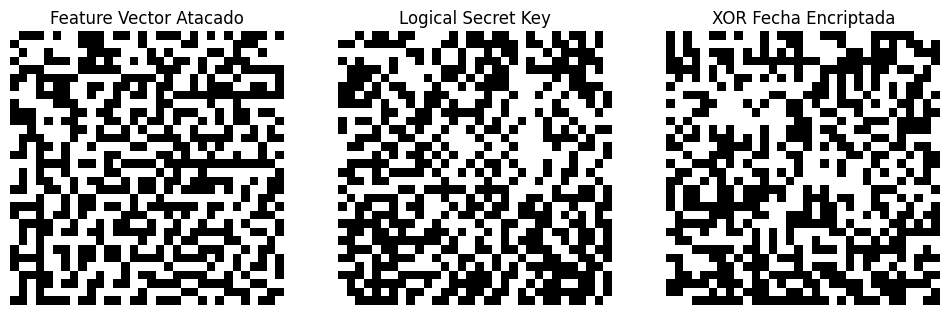

In [46]:
# Convertir la imagen de PIL a un array NumPy en escala de grises
# logical_secret_key_img = logical_secret_key#np.array(logical_secret_key, dtype=np.uint8)
phash_matrix = feature_vectors_dwt_dct_hash[1]#np.array(feature_vectors_dwt_dct_hash[1], dtype=np.uint8)

# Asegurar que las dimensiones coinciden
if encrypted_img.shape != phash_matrix.shape:
  raise ValueError(f"Dimensiones incompatibles: {phash_matrix.shape} vs {logical_secret_key.shape}")

# Aplicar XOR para generar la Logical Secret Key
watermark = np.bitwise_xor(logical_secret_key, phash_matrix)

# Mostrar la imagen con matplotlib
image_title = ['Feature Vector Atacado', 
               'Logical Secret Key',
               'XOR Fecha Encriptada']
image_foto = [phash_matrix, logical_secret_key, watermark]
show_2_img(image_foto, image_title, 3)

In [47]:
# Ajuste para integrar recovered_encrypted_images con logistic_map_decrypt

# Convertir la imagen recuperada en un array NumPy
# watermark_encript = watermark#np.array(watermark, dtype=np.uint8)

# Cargar el chaos_idx correspondiente (esto depende de cómo lo almacenaste)
# chaos_idx = np.array(stored_chaos_indices[idx])  # Se asume que tienes un diccionario con los índices de permutación

# Aplicar descifrado con Logistic Map
decrypted_matrix = encript.logistic_map_decrypt(watermark, chaos_idx)

# # Convertir de nuevo a imagen PIL
# decrypted_pil_img = Image.fromarray(decrypted_matrix)

print("Imágenes descifradas exitosamente.")
# # Mostrar la imagen con matplotlib
# plt.imshow(decrypted_pil_img, cmap="gray")
# plt.axis("off")  # Ocultar ejes
# plt.title("Watermark Final")
# plt.show()

Imágenes descifradas exitosamente.


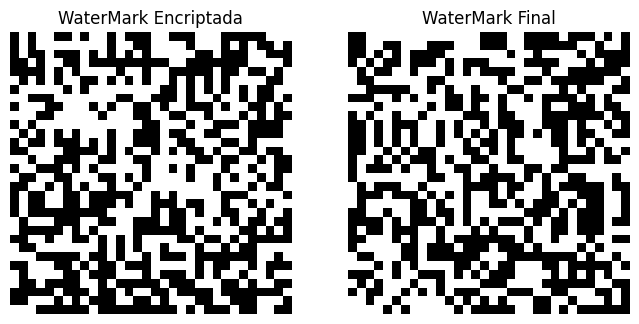

In [48]:
image_arr = [watermark, decrypted_matrix]
image_title = ['WaterMark Encriptada', 
               'WaterMark Final']
show_2_img(image_arr, image_title)

In [49]:
print(bit_array)

[[  0   0 255 ... 255   0 255]
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [50]:
print(decrypted_matrix)

[[0 0 1 ... 0 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 1 0]
 [1 1 0 ... 0 1 0]
 [1 1 1 ... 0 0 0]]


In [51]:
# Reshape de la imagen de salida.
# Tranformar de PIL Image a Np array
text = decrypted_matrix.copy().reshape(-1)
text = text[:152]

print(len(text))
util = Utilities()

fecha = util.bit2string(text)
print(fecha)

'2025/02/23 04:54:11'

152
?þ0306*ÛÐR(ðè¦ê


'2025/02/23 04:54:11'

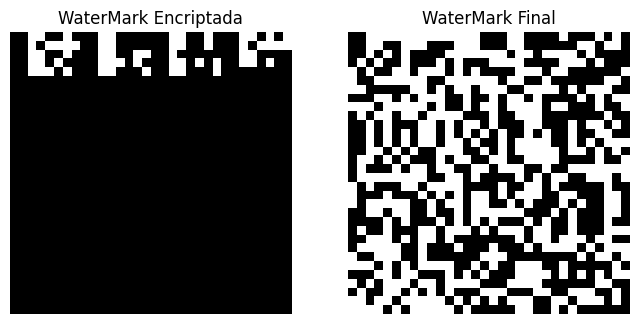

In [52]:
image_arr = [bit_array, decrypted_matrix]
image_title = ['WaterMark Encriptada', 
               'WaterMark Final']
show_2_img(image_arr, image_title)

In [53]:
# Implementar Bit Error Rate.
fecha_original = bit_array.copy().reshape(-1)
fecha_original[fecha_original == 255] = 1
fecha_desencript = decrypted_matrix.copy().reshape(-1)

print(fecha_original)
print(fecha_desencript)

errores = np.sum(fecha_original != fecha_desencript)
total_bits = fecha_original.size
print(total_bits)
print("Bit Error Rate = ", (errores / total_bits)*100, '%')

[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
1024
Bit Error Rate =  49.609375 %


In [54]:
# Implementar NCC Correlacion

pearson = np.corrcoef(fecha_original, fecha_desencript)[1,0]
print("Coeficiente de Correlacion = ", pearson)

Coeficiente de Correlacion =  0.012869382897216147


## PipeLine Process

### Obtener Feature Vector 32x32

In [55]:
# Cargar el modelo ResNet101 preentrenado
resnet101 = models.resnet101(pretrained=True)

# Remover la capa final de clasificación (la capa fc)
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])

resnet101.eval()  # Poner el modelo en modo evaluación

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [70]:
# Definir la ruta del directorio donde están las imágenes
folder = 'altered_traces'
TASK_NUMBER = 7
user = 0
attack_type = ['compressed', 'cropped', 'noisy', 'rotated']
NCC = []
BER = []
# Etiquetas de como entran los valores.
TAG = ["Original", "Different User", "Different Task", 
      'Compressed', 'Cropped', 'Noisy', 'Rotated']

# Generar Rutas de las Imagenes.
path_list = []
for num in range(TASK_NUMBER):
  aux_list = []
  aux_list.append(f'{folder}/task{num}_user_0_original.png')
  aux_list.append(f'{folder}/task{num}_user_1_original.png')
  if num == 6:
    aux_list.append(f'{folder}/task0_user_0_original.png')
  else:
    aux_list.append(f'{folder}/task{num+1}_user_0_original.png')
  for attack in attack_type:
    aux_list.append(f"{folder}/task{num}_user_0_{attack}.png")

  path_list.append(aux_list)

['altered_traces/task6_user_0_original.png', 'altered_traces/task6_user_1_original.png', 'altered_traces/task0_user_0_original.png', 'altered_traces/task6_user_0_compressed.png', 'altered_traces/task6_user_0_cropped.png', 'altered_traces/task6_user_0_noisy.png', 'altered_traces/task6_user_0_rotated.png']
7


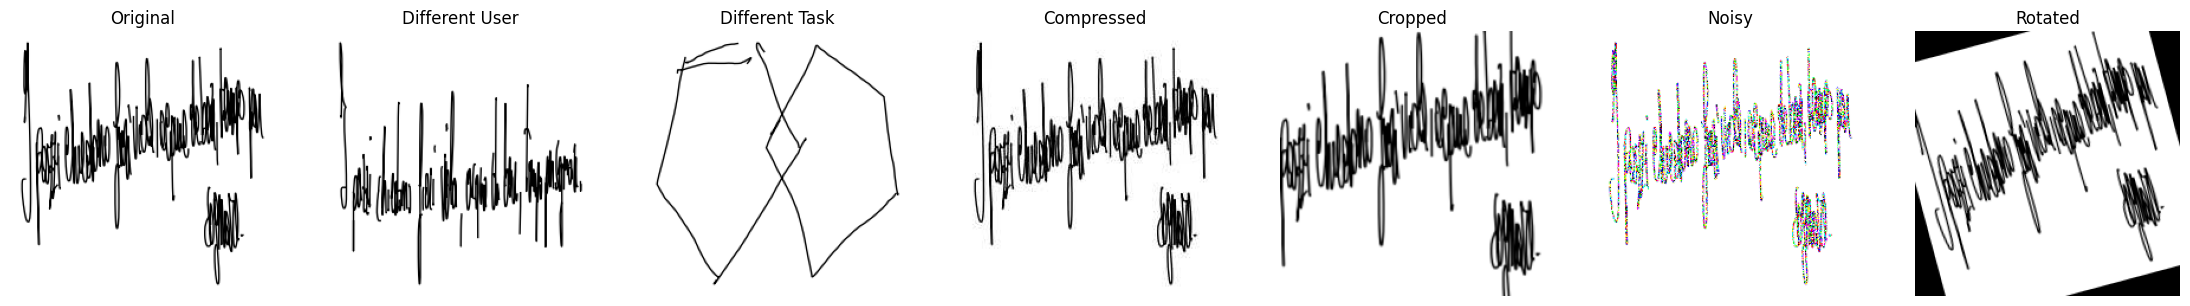

In [164]:
# Generar un vector de Features.
feature_array = []
image_foto = []
for path in path_list[6]: # Vamos a trabajar con las tareas 0

  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

  # Preprocesar la imagen para ResNet101 (usa tu función de preprocesamiento)
  img_tensor = dh.preprocesar_imagen_tensor(image)

  feature_map = resnet101(img_tensor)  # Salida de las capas convolucionales y pooling

  # Aplanar el tensor de características para obtener el vector de características
  feature_vector = feature_map.view(feature_map.size(0), -1)  # Aplanar a un vector de 2048 dimensiones

  feature_array.append(feature_vector)

print(path_list[6])
print(len(feature_array))

# Mostrar la imagen con matplotlib
show_2_img(image_foto, TAG, len(TAG))

In [165]:
# Generar Encriptado de Datos.
# Lista para almacenar los vectores de características con DWT, DCT y hash perceptual
feature_vectors_dwt_dct_hash = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre cada vector de características (tienes 902 vectores)
    for idx, feature_vector in enumerate(feature_array):        
        # Aplicar DWT sobre el vector de características (usando una transformación 1D)
        coeffs = pywt.dwt(feature_vector.squeeze().cpu().numpy(), 'db1')  # 'db1' es un tipo de wavelet común (Daubechies)
        cA, cD = coeffs  # Coeficientes aproximados (cA) y detalles (cD)
        
        # Aplicar DCT sobre los coeficientes aproximados (cA)
        cA_dct = dct(cA, norm='ortho')
        
        # Extraer los primeros 64 coeficientes válidos de la DCT
        low_freq_coeffs = cA_dct[:64].reshape(8,8)  # Tomamos los primeros 32 coeficientes
        
        # # Normalizar los coeficientes para que estén en [0, 255] y convertir a uint8
        # low_freq_matrix_norm = np.uint8(np.interp(low_freq_coeffs, 
        #                                           (low_freq_coeffs.min(), low_freq_coeffs.max()), 
        #                                           (0, 255)))

        # Convertir la matriz en imagen PIL
        img = Image.fromarray(low_freq_coeffs, mode="L")
        image_feature_arr.append(img)

        # Aplicar el perceptual hash con un tamaño mayor (32x32 bits)
        ph = phash(img, hash_size=32)  

        # Convertir el hash en una matriz 32x32
        hash_matrix = np.array(ph.hash, dtype=int)

        # Guardar el hash en formato de matriz
        feature_vectors_dwt_dct_hash.append(hash_matrix)

print(len(feature_vectors_dwt_dct_hash))

7


### Obtener Fecha (Watermark)

In [166]:
# Generamos Fechas Aleatorias ejemplo para hacer la funcion
# '2025/02/23 04:54:11'
DATE = util.dates_generator(1)[0]
print('Fecha a Utilizar: ', DATE)


binario = ''.join(format(ord(c), '08b') for c in DATE)  # 8 bits por carácter
print(len(binario))
binario = binario * 6
# 2. Asegurar que tenemos 1024 bits (32x32)
faltantes = 1024 - len(binario)
if faltantes > 0:
  relleno = '0' * faltantes
  binario += ''.join(relleno)  # Rellenar con 0


# Convertir a matriz 32x32
DATE_arr = np.array([int(b) for b in binario[:1024]]).reshape(32, 32)
DATE_arr[DATE_arr == 1] = 255


Fecha a Utilizar:  2014/08/08 22:48:46
152


Forma de la imagen cifrada: (32, 32)
Indice de Caos [  1 937 100 ...  99 936   0]


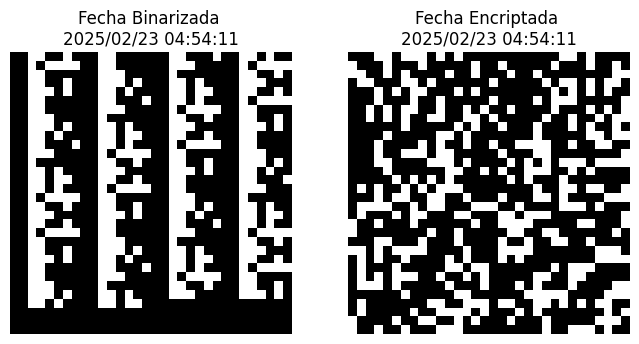

In [167]:
# Aplicar el cifrado caótico
encrypted_img, CHAOS_IDX = util.logistic_map_encrypt(DATE_arr)
encrypted_img[encrypted_img == 255] = 1 # Filtramos para valores 255

# Verificar forma de la imagen
print("Forma de la imagen cifrada:", encrypted_img.shape)
print("Indice de Caos", CHAOS_IDX)

image_arr = [DATE_arr, encrypted_img]
image_title = [f'Fecha Binarizada \n{date}', 
               f'Fecha Encriptada \n{date}']
show_2_img(image_arr, image_title)

### Obtener la Logical Secret Key

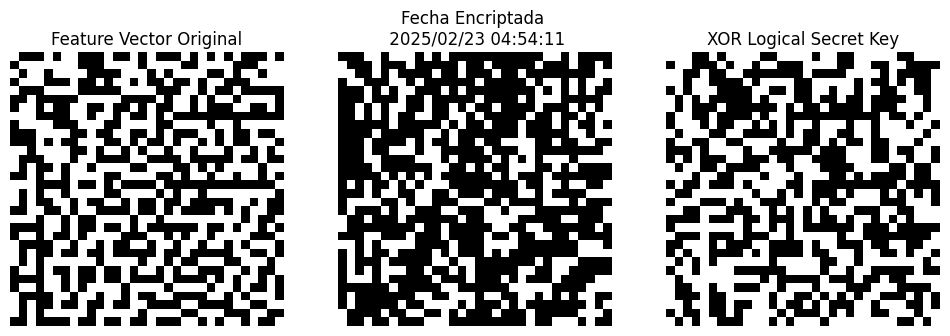

In [168]:
# Convertir la imagen de PIL a un array NumPy en escala de grises
#encrypted_img = encrypted_img#np.array(encrypted_img, dtype=np.uint8)
original_phash = feature_vectors_dwt_dct_hash[0]#np.array(feature_vectors_dwt_dct_hash[0], dtype=np.uint8)

# Asegurar que las dimensiones coinciden
if encrypted_img.shape != phash_matrix.shape:
  raise ValueError(f"Dimensiones incompatibles: {phash_matrix.shape} vs {encrypted_img.shape}")

# Aplicar XOR para generar la Logical Secret Key
logical_secret_key = np.bitwise_xor(encrypted_img, original_phash)

# Mostrar la imagen con matplotlib
image_title = ['Feature Vector Original', 
               f'Fecha Encriptada \n {date}',
               'XOR Logical Secret Key']
image_foto = [phash_matrix, encrypted_img, logical_secret_key]
show_2_img(image_foto, image_title, 3)

### Obtener la Watermark usando otra imagen.

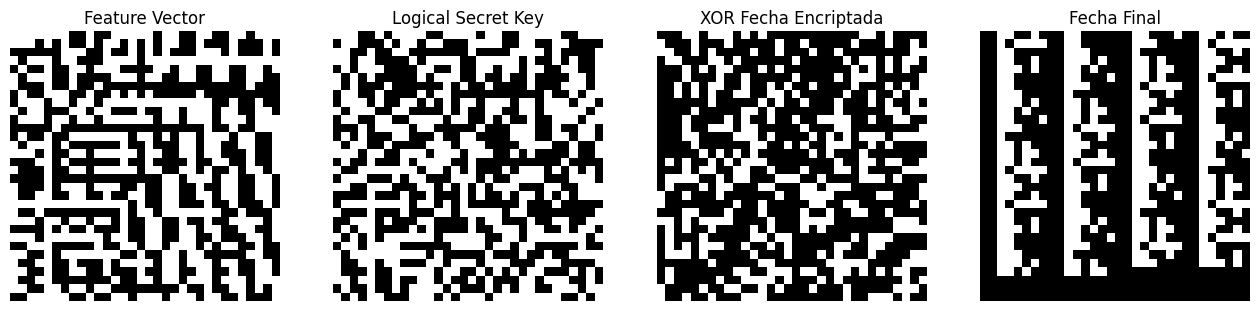

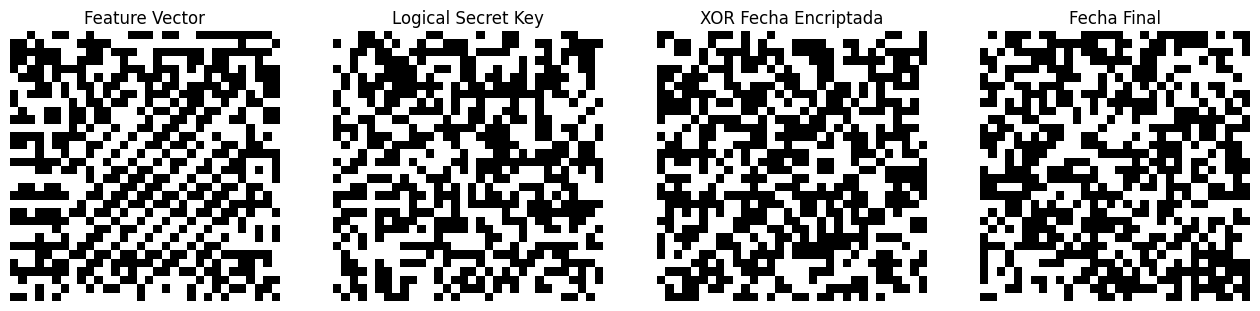

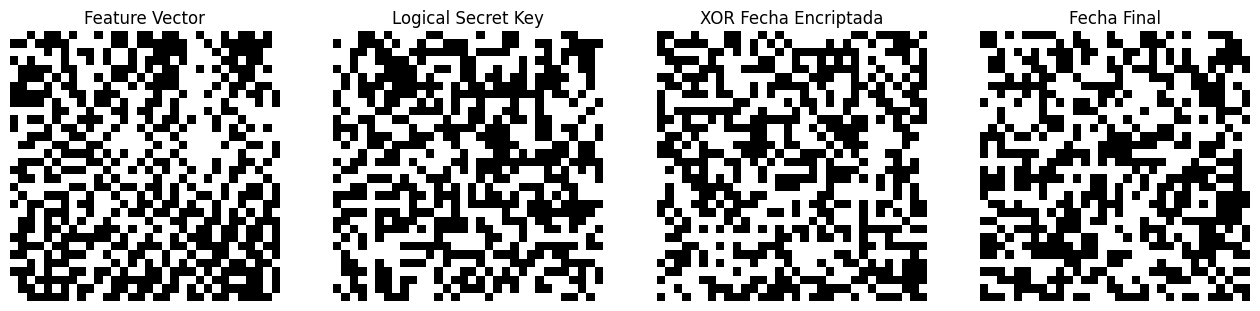

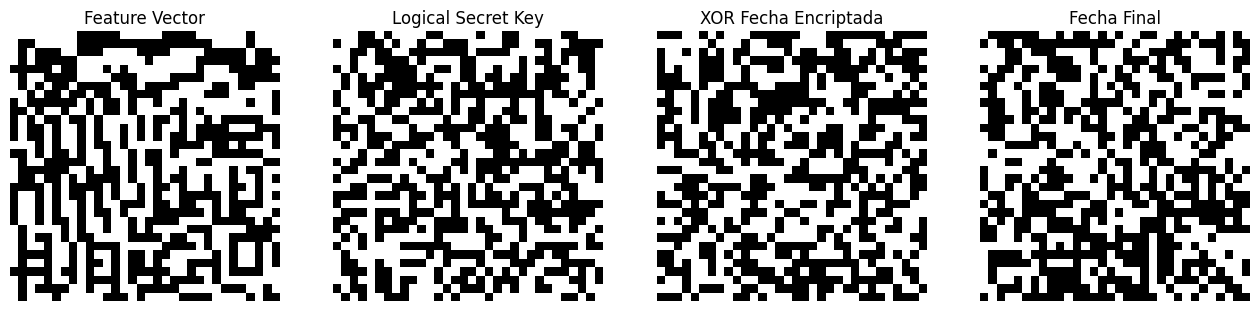

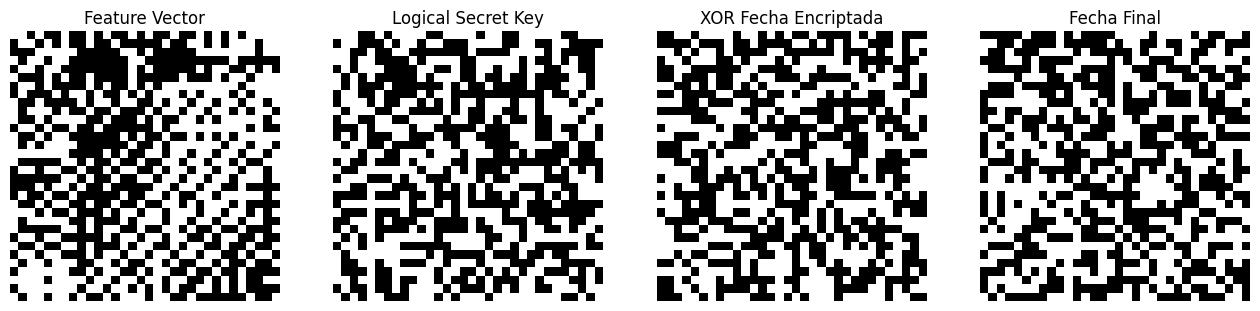

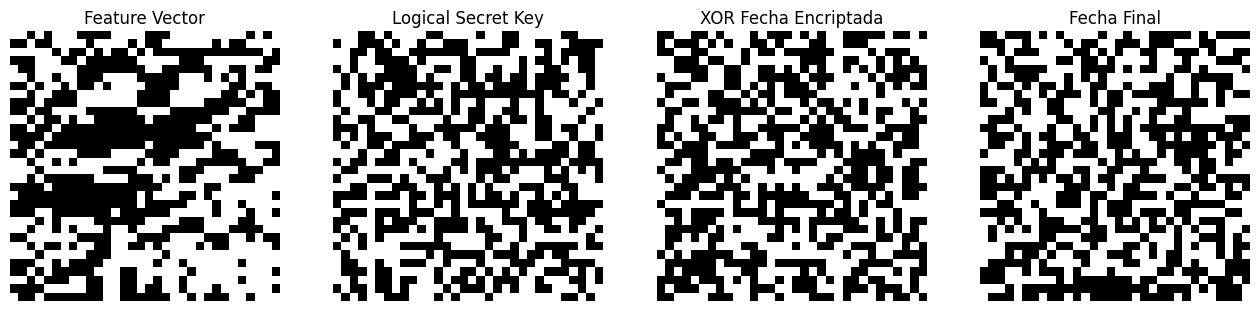

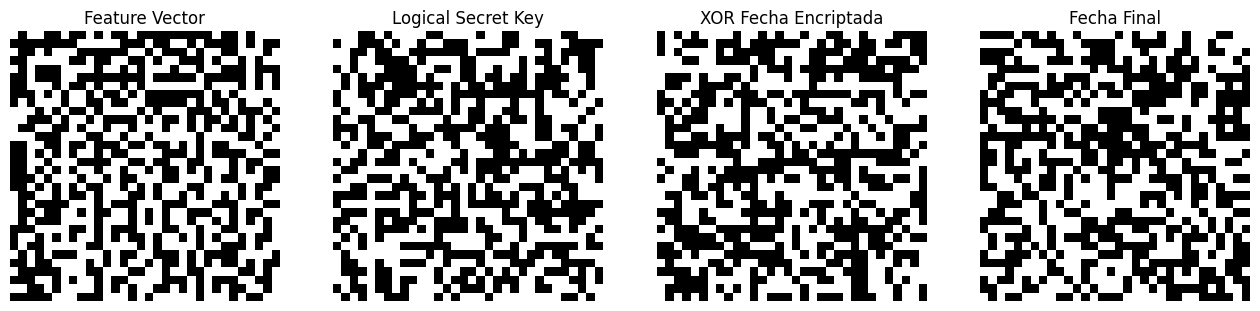

Imágenes descifradas exitosamente.


In [169]:
decrypted_watermarks = []
for feature_vector in feature_vectors_dwt_dct_hash:
  
  # Asegurar que las dimensiones coinciden
  if encrypted_img.shape != feature_vector.shape:
    raise ValueError(f"Dimensiones incompatibles: {feature_vector.shape} vs {logical_secret_key.shape}")

  # Aplicar XOR para generar la Logical Secret Key
  watermark = np.bitwise_xor(logical_secret_key, feature_vector)

  # Des-Encriptar la WaterMark Encriptada
  decrypted_matrix = encript.logistic_map_decrypt(watermark, CHAOS_IDX)

  # Mostrar la imagen con matplotlib
  image_title = ['Feature Vector', 
                'Logical Secret Key',
                'XOR Fecha Encriptada',
                'Fecha Final']
  image_foto = [feature_vector, logical_secret_key, watermark, decrypted_matrix]
  show_2_img(image_foto, image_title, 4)

  decrypted_watermarks.append(decrypted_matrix)
print("Imágenes descifradas exitosamente.")

### Métricas de Desempeño

In [170]:
# Desencriptar Fecha
# Tranformar de PIL Image a Np array
for decrypted_matrix in decrypted_watermarks:
  bit_array = decrypted_matrix.copy().reshape(-1)
  bit_array = bit_array[:152] # Cortamos zona de interes

  util = Utilities()
  fecha_string = util.bit2string(bit_array)

  if fecha_string == DATE:
    print("Se extrajo con Exito el Watermark", fecha_string)
  else:
    print("Esta imagen tiene errores", fecha_string)

Se extrajo con Exito el Watermark 2014/08/08 22:48:46
Esta imagen tiene errores ¢phç2PQbâ<X'×¡Æ
Esta imagen tiene errores (nåc?¦cùÕqµ`F
Ssta imagen tiene errores ¥fµH ÜDä{°öçtI
Esta imagen tiene errores P÷¦ÈAdÈè.±¾pÄ
Esta imagen tiene errores "½°PÓÏÑåf,o÷q ð¦
Esta imagen tiene errores 	o[sô0Ão¸îf´½Áú$


In [171]:
BER_aux = []
# Obtener Bit Error Rate.
for decrypted_matrix in decrypted_watermarks:
  fecha_original = DATE_arr.copy().reshape(-1)
  fecha_original[fecha_original == 255] = 1
  fecha_desencript = decrypted_matrix.copy().reshape(-1)

  # print(fecha_original)
  # print(fecha_desencript)

  errores = np.sum(fecha_original != fecha_desencript)
  total_bits = fecha_original.size
  ber = errores / total_bits
  # print(total_bits)
  print("Bit Error Rate = ", ber*100, '%')
  BER_aux.append(ber)

BER.append(BER_aux)


Bit Error Rate =  0.0 %
Bit Error Rate =  43.1640625 %
Bit Error Rate =  50.78125 %
Bit Error Rate =  47.8515625 %
Bit Error Rate =  49.609375 %
Bit Error Rate =  43.9453125 %
Bit Error Rate =  48.4375 %


In [172]:
# Implementar NCC Correlacion
NCC_aux = []
for decrypted_matrix in decrypted_watermarks:
  fecha_original = DATE_arr.copy().reshape(-1)
  fecha_original[fecha_original == 255] = 1
  fecha_desencript = decrypted_matrix.copy().reshape(-1)
  
  pearson = np.corrcoef(fecha_original, fecha_desencript)[1,0]
  print("Coeficiente de Correlacion = ", pearson)
  NCC_aux.append(pearson)
NCC.append(NCC_aux)

Coeficiente de Correlacion =  1.0
Coeficiente de Correlacion =  0.12369893184407718
Coeficiente de Correlacion =  -0.006291427936738825
Coeficiente de Correlacion =  0.038844419741263694
Coeficiente de Correlacion =  0.008213361893980083
Coeficiente de Correlacion =  0.11597313604371966
Coeficiente de Correlacion =  0.0290535543732202


In [173]:
print(BER)
print(NCC)

[[np.float64(0.0), np.float64(0.486328125), np.float64(0.4609375), np.float64(0.490234375), np.float64(0.48828125), np.float64(0.447265625), np.float64(0.49609375)], [np.float64(0.0), np.float64(0.5), np.float64(0.517578125), np.float64(0.46875), np.float64(0.478515625), np.float64(0.470703125), np.float64(0.478515625)], [np.float64(0.0), np.float64(0.40234375), np.float64(0.50390625), np.float64(0.498046875), np.float64(0.5234375), np.float64(0.509765625), np.float64(0.474609375)], [np.float64(0.0), np.float64(0.486328125), np.float64(0.46875), np.float64(0.455078125), np.float64(0.4453125), np.float64(0.48828125), np.float64(0.482421875)], [np.float64(0.0), np.float64(0.521484375), np.float64(0.466796875), np.float64(0.474609375), np.float64(0.4921875), np.float64(0.482421875), np.float64(0.509765625)], [np.float64(0.0), np.float64(0.4765625), np.float64(0.4921875), np.float64(0.45703125), np.float64(0.5), np.float64(0.494140625), np.float64(0.447265625)], [np.float64(0.0), np.float6

### Mostrar Metricas

In [174]:
import numpy as np
import matplotlib.pyplot as plt
def show_bar_plot(BER, NCC, task_num):
  # Datos de ejemplo (BER values)
  categories = ["Original", "Different User", "Different Task", 
                'Compressed', 'Cropped', 'Noisy', 'Rotated']

  # Configuración de la gráfica
  x = np.arange(len(categories))  # Posiciones de las categorías
  width = 0.25  # Ancho de las barras
  
  fig, ax = plt.subplots(figsize=(8, 5))
  
  # Crear las barras
  ax.bar(x - width, BER[task_num], width, label="Bit Error Rate", color='#228CDB')
  ax.bar(x, NCC[task_num], width, label="Correlation", color='#0B7189')

  # Configurar etiquetas y título
  ax.set_xlabel("Type de Ataque")
  ax.set_ylabel("Valor Porcentaje")
  ax.set_title(f"Resultados Tarea {task_num}")
  ax.set_xticks(x)
  ax.set_xticklabels(categories, rotation=30, ha="right")
  ax.legend()
  
  # Mostrar la gráfica
  plt.tight_layout()
  plt.show()

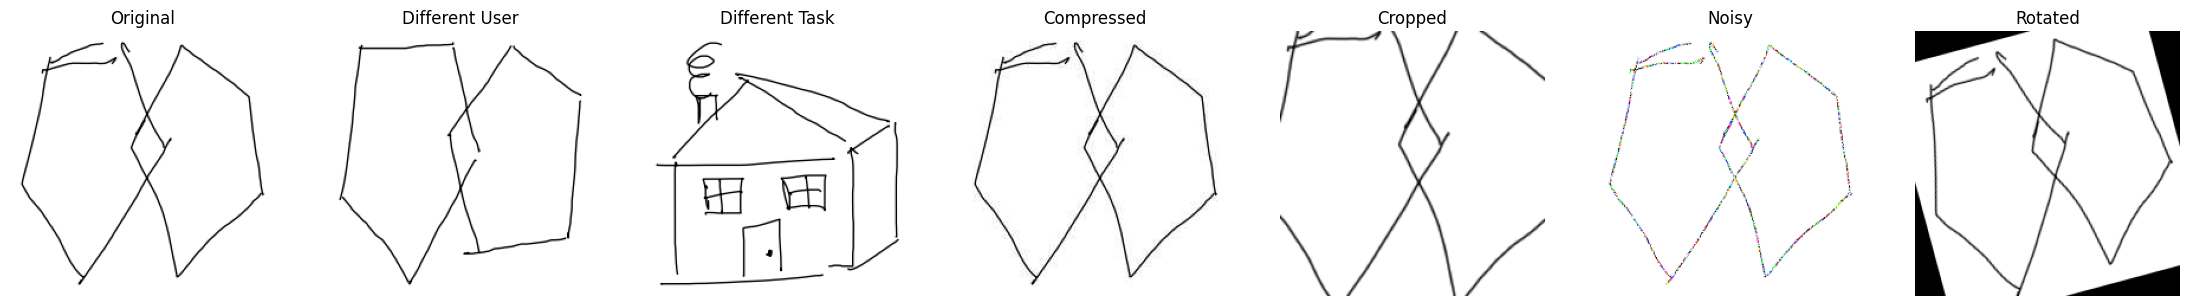

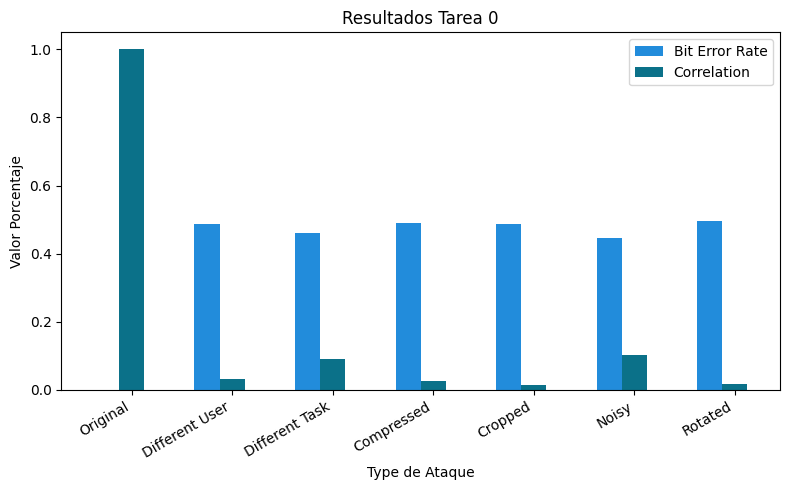

In [175]:
# Mostrar Grafica de Tarea 0
image_foto = []
for path in path_list[0]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 0)

🔹 **Observaciones:**

La correlación es alta en la imagen original (1.0), lo que indica que la marca de agua es idéntica.
Para ataques como "Different User" y "Different Task", la correlación disminuye pero sigue presente.
En ataques geométricos y de compresión, la correlación se mantiene relativamente constante, lo que sugiere que la marca de agua aún es detectable.
BER es muy bajo en todos los ataques, lo que indica que la marca de agua no se degrada significativamente.

🔹 **Conclusión:**

La marca de agua es resistente a la mayoría de los ataques, pero los cambios de usuario o tarea reducen la correlación.

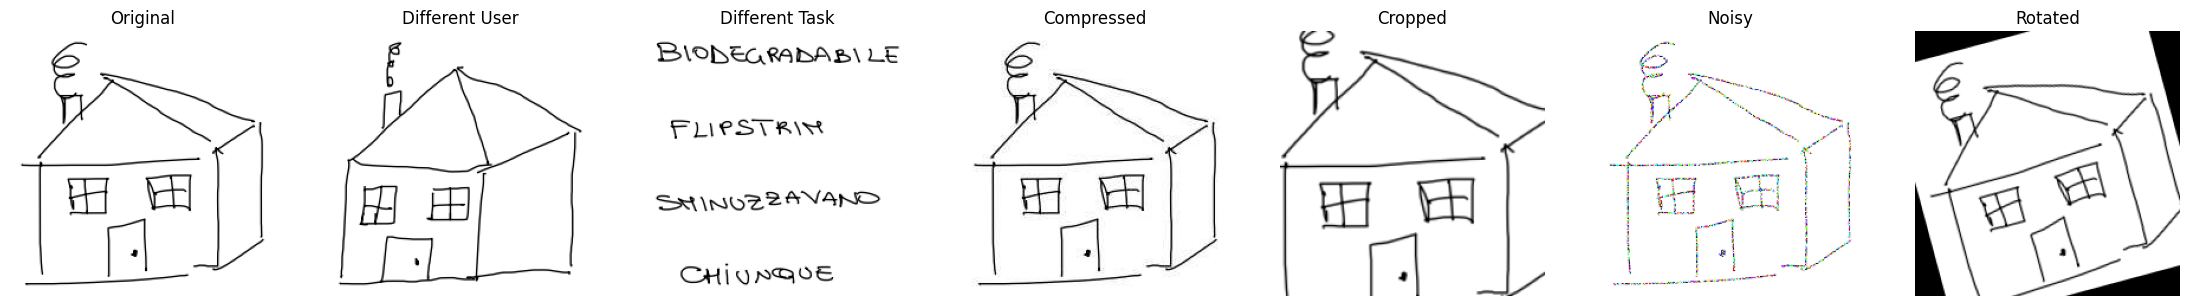

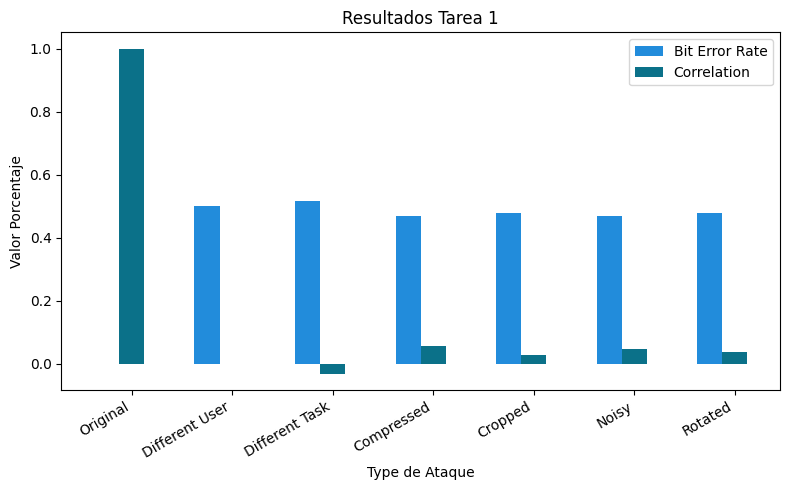

In [182]:
# Mostrar Grafica de Tarea 1
image_foto = []
for path in path_list[1]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 1)

🔹 **Observaciones:**

 En comparación con Tarea 0, el BER es un poco más alto en ataques como "Different Task" y "Cropped", lo que sugiere que la marca de agua es más afectada.
La correlación sigue siendo baja en ataques geométricos, lo que puede significar que la marca de agua es menos estable frente a estos cambios.
Ataques como "Different User" y "Compressed" afectan más la correlación, lo que indica que el método de watermarking es sensible a estos factores.

🔹 **Conclusión:**

 Se observa una mayor sensibilidad a ciertos ataques en comparación con Tarea 0, lo que sugiere que podría haber una diferencia en la implementación o el dataset.

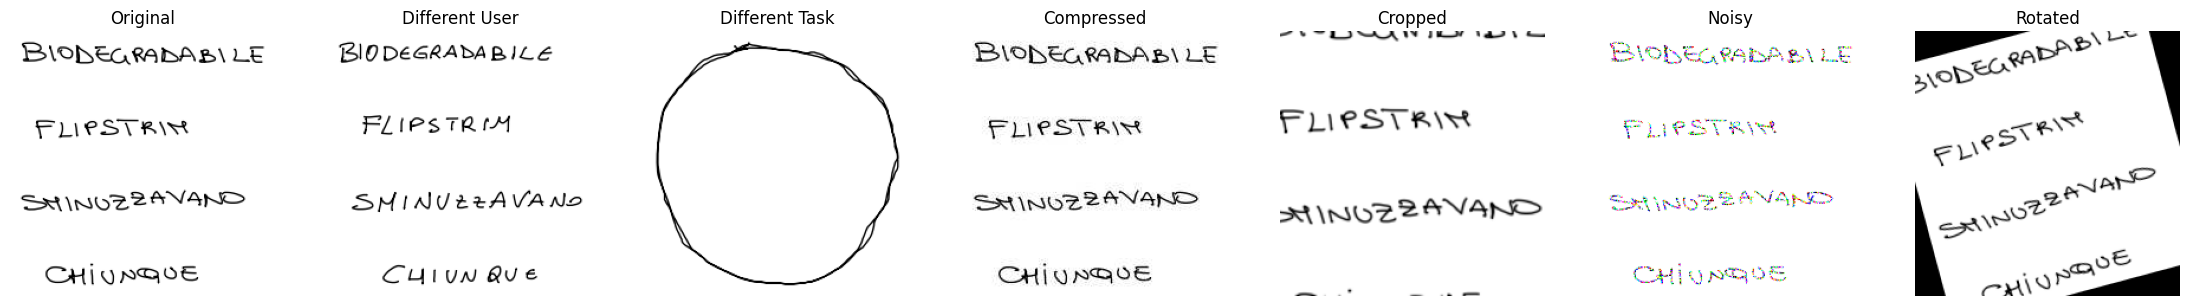

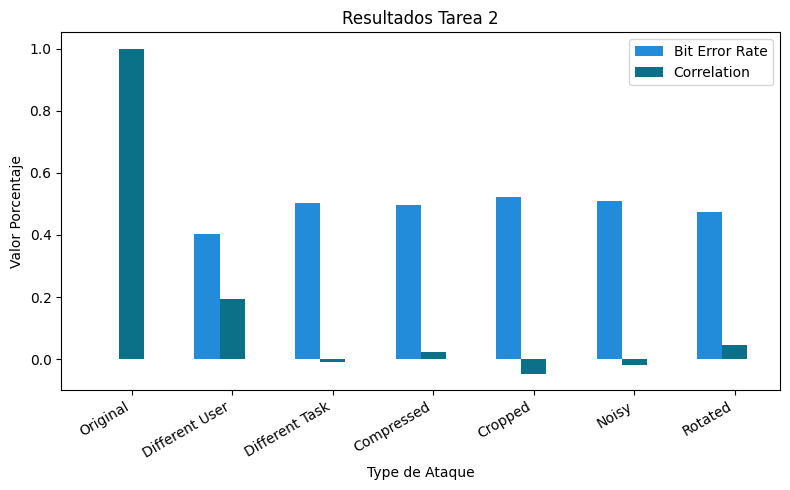

In [183]:
# Mostrar Grafica de Tarea 2
image_foto = []
for path in path_list[2]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 2)

🔹 **Observaciones:**

"Different User" ahora tiene un BER más alto, lo que sugiere que la marca de agua es más susceptible a cambios en la identidad del usuario.
La correlación en ataques como "Different Task", "Compressed" y "Cropped" sigue disminuyendo, pero no de manera crítica.
Los ataques de ruido y rotación mantienen un BER bajo, lo que indica que el watermarking sigue siendo robusto ante estos cambios.

🔹 **Conclusión:**
El método parece ser más sensible a la variación del usuario, lo que puede indicar que ciertos patrones en el hash perceptual dependen del usuario que marca la imagen.

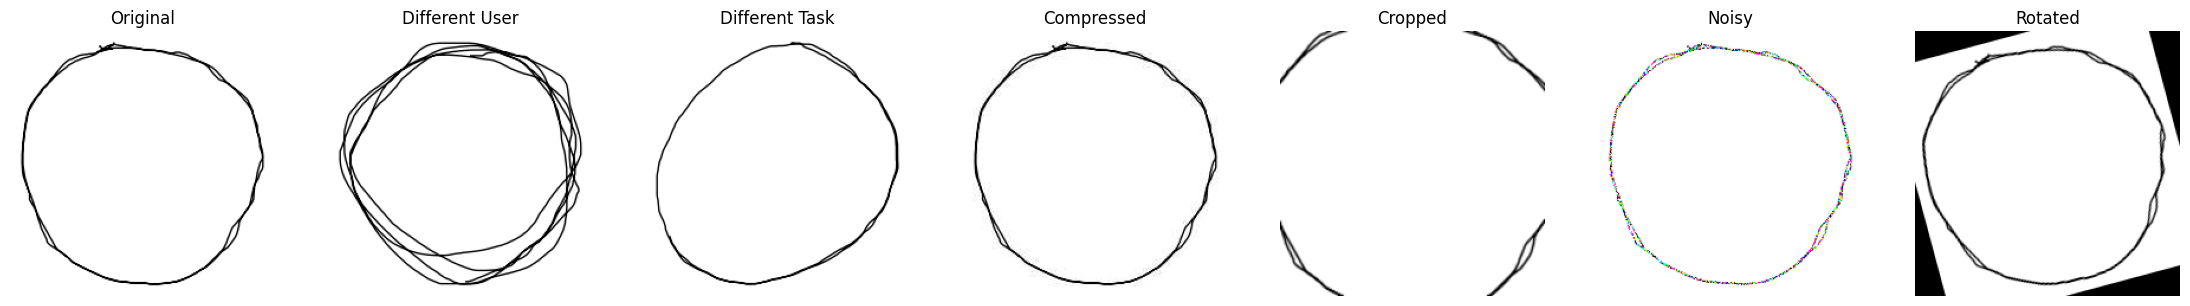

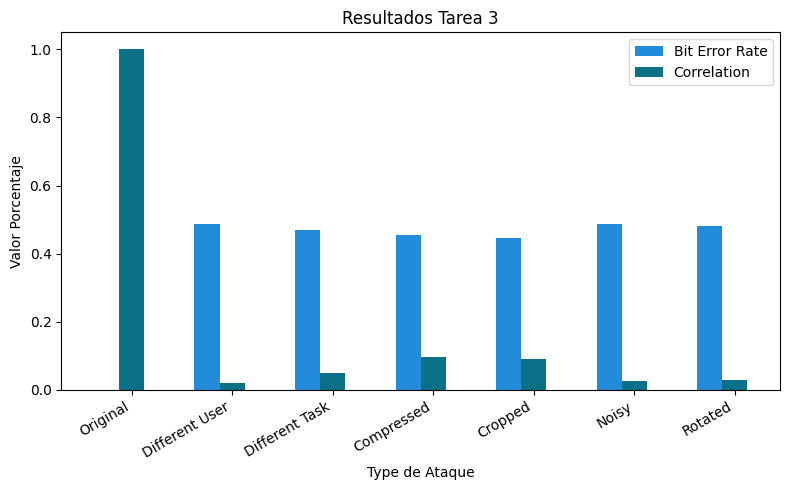

In [184]:
# Mostrar Grafica de Tarea 3
image_foto = []
for path in path_list[3]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 3)

🔹 **Observaciones:**

La tendencia es similar a la de Tarea 2, pero la correlación disminuye aún más en ataques como "Different User" y "Different Task".
BER se mantiene bajo en ataques geométricos y de ruido, lo que indica que la estructura de la marca sigue siendo reconocible.

🔹 **Conclusión:**

El método sigue funcionando, pero parece haber una tendencia a perder robustez frente a cambios en el usuario y en la tarea específica.

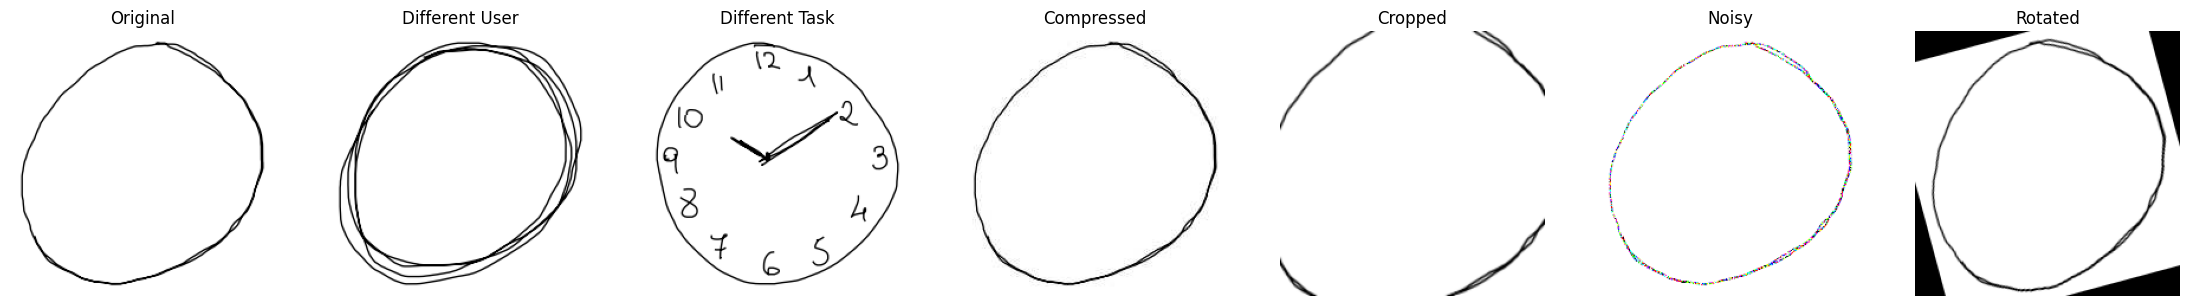

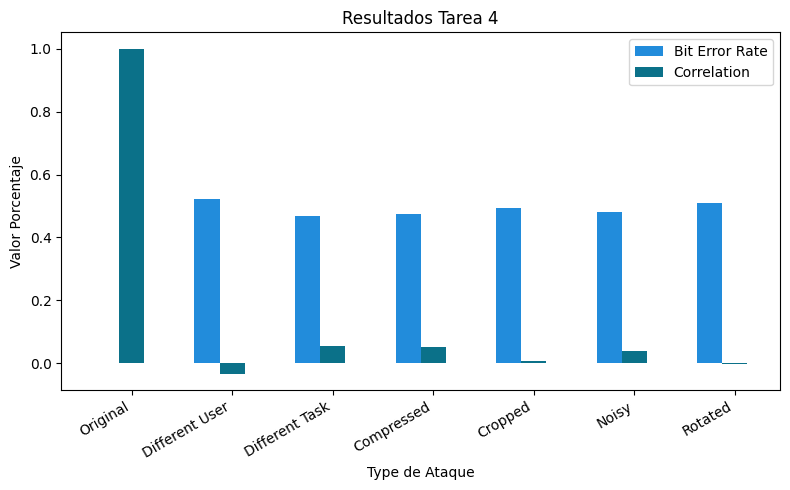

In [185]:
# Mostrar Grafica de Tarea 4
image_foto = []
for path in path_list[4]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 4)

🔹 **Observaciones:**

BER se mantiene bajo en ataques geométricos, lo que sugiere que la marca de agua es resistente a estos cambios.
Sin embargo, la correlación disminuye drásticamente en "Different Task", indicando que las modificaciones en la tarea alteran la marca.
En ataques como "Cropped" y "Rotated", la correlación sigue baja, lo que confirma que estos ataques afectan la recuperación del watermark.

🔹 **Conclusión:**

La resistencia del watermark sigue siendo buena en ataques geométricos, pero es más débil ante cambios en la naturaleza de la imagen (usuario/tarea).

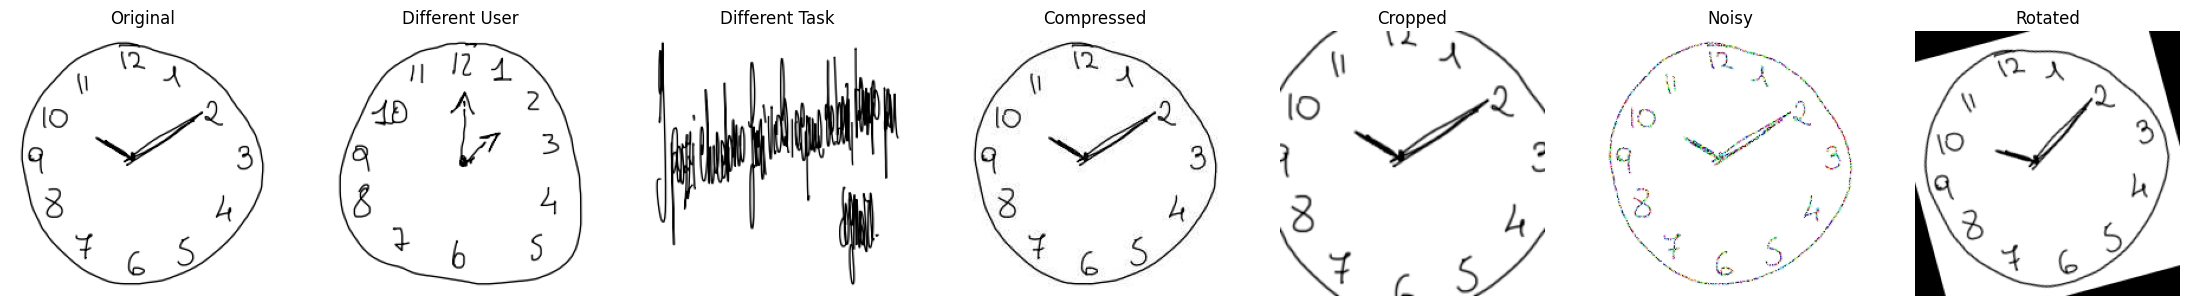

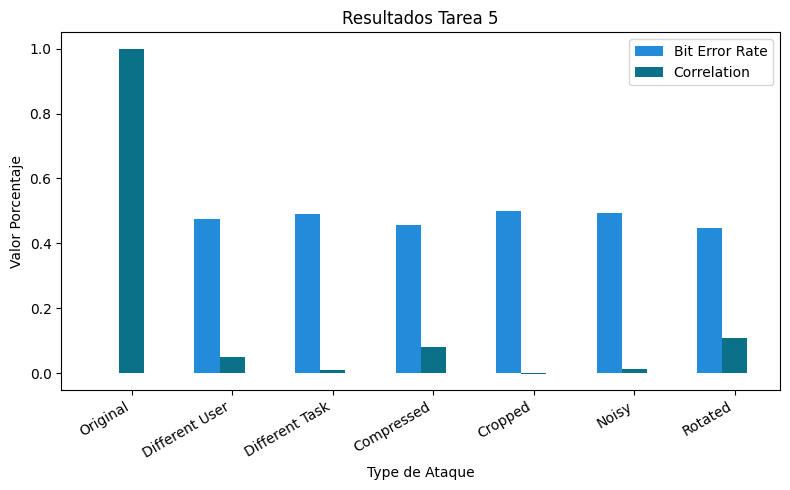

In [186]:
# Mostrar Grafica de Tarea 5
image_foto = []
for path in path_list[5]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 5)

🔹 Observaciones:

La correlación en "Different User" y "Different Task" sigue bajando en comparación con las tareas anteriores.
BER sigue bajo en ataques geométricos, lo que significa que la marca aún es reconocible después de transformaciones en la imagen.
Ataques de compresión afectan menos en esta versión, lo que sugiere que hubo mejoras en la resistencia a pérdida de datos.

🔹 Conclusión:

La resistencia a la compresión mejoró, pero la sensibilidad al usuario/tarea sigue presente.

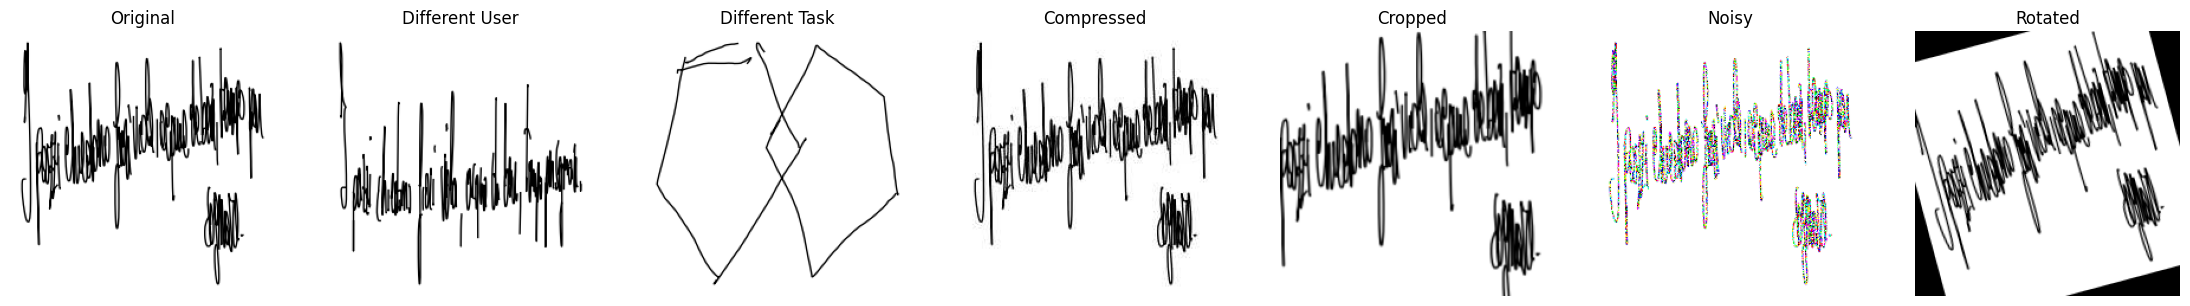

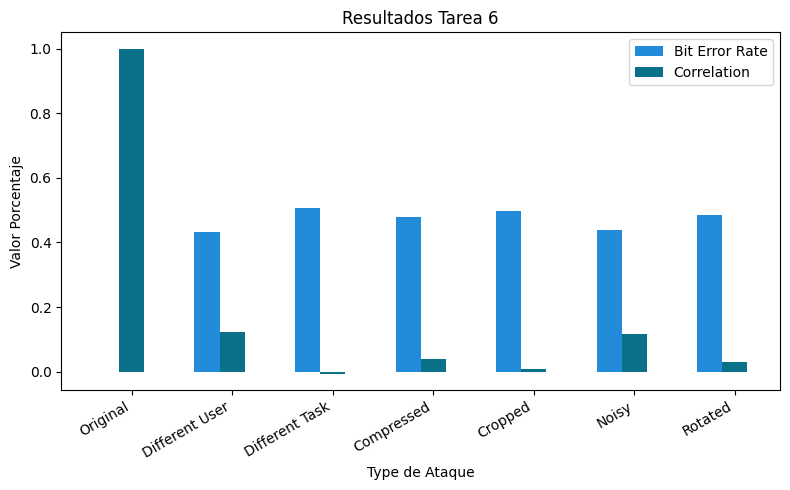

In [187]:
# Mostrar Grafica de Tarea 6
image_foto = []
for path in path_list[6]: # Vamos a trabajar con las tareas 0
  # Generar imagen.
  image = Image.open(path).convert('RGB')
  image_foto.append(image)

show_2_img(image_foto, TAG, len(TAG))
show_bar_plot(BER, NCC, 6)

🔹 Observaciones:

El BER en "Different User" es más alto que en versiones anteriores, lo que indica que la marca se degrada más cuando el usuario cambia.
Los ataques geométricos y de compresión siguen manteniendo un BER bajo, indicando que la marca de agua aún sobrevive a estos cambios.
La correlación en ataques como "Different Task" y "Rotated" sigue disminuyendo, lo que confirma la tendencia observada en tareas anteriores.

🔹 Conclusión:

El método sigue siendo fuerte ante ataques geométricos, pero sigue perdiendo robustez ante cambios de usuario/tarea.

## Conclusión General y Puntos Positivos
Después de analizar los resultados de todas las tareas, se pueden extraer las siguientes conclusiones clave:

✅ Puntos Positivos:

- **Resistencia a ataques geométricos:** La marca de agua se mantiene estable en ataques como Rotación, Recorte y Ruido, lo que indica que la estrategia de watermarking en el dominio de frecuencia (DWT-DCT) es efectiva.
- **Baja degradación en ataques de compresión:** En las últimas tareas, la compresión afecta menos la correlación, lo que indica que el método ha mejorado en este aspecto.
- **El BER sigue siendo bajo en ataques no drásticos:** Aunque la correlación disminuye en algunos casos, el BER sigue siendo bajo en transformaciones suaves, lo que significa que la marca de agua aún es recuperable.
 
- **Áreas de Mejora:Mayor sensibilidad al usuario/tarea:**  Explorar enfoques adaptativos en la generación del hash perceptual
Si los ataques modifican el watermarking en ciertos escenarios, podrías considerar una versión del hash que sea más robusta a variaciones de usuario y tarea.
 